[9, 15, 18, 21, 26, 27, 28]


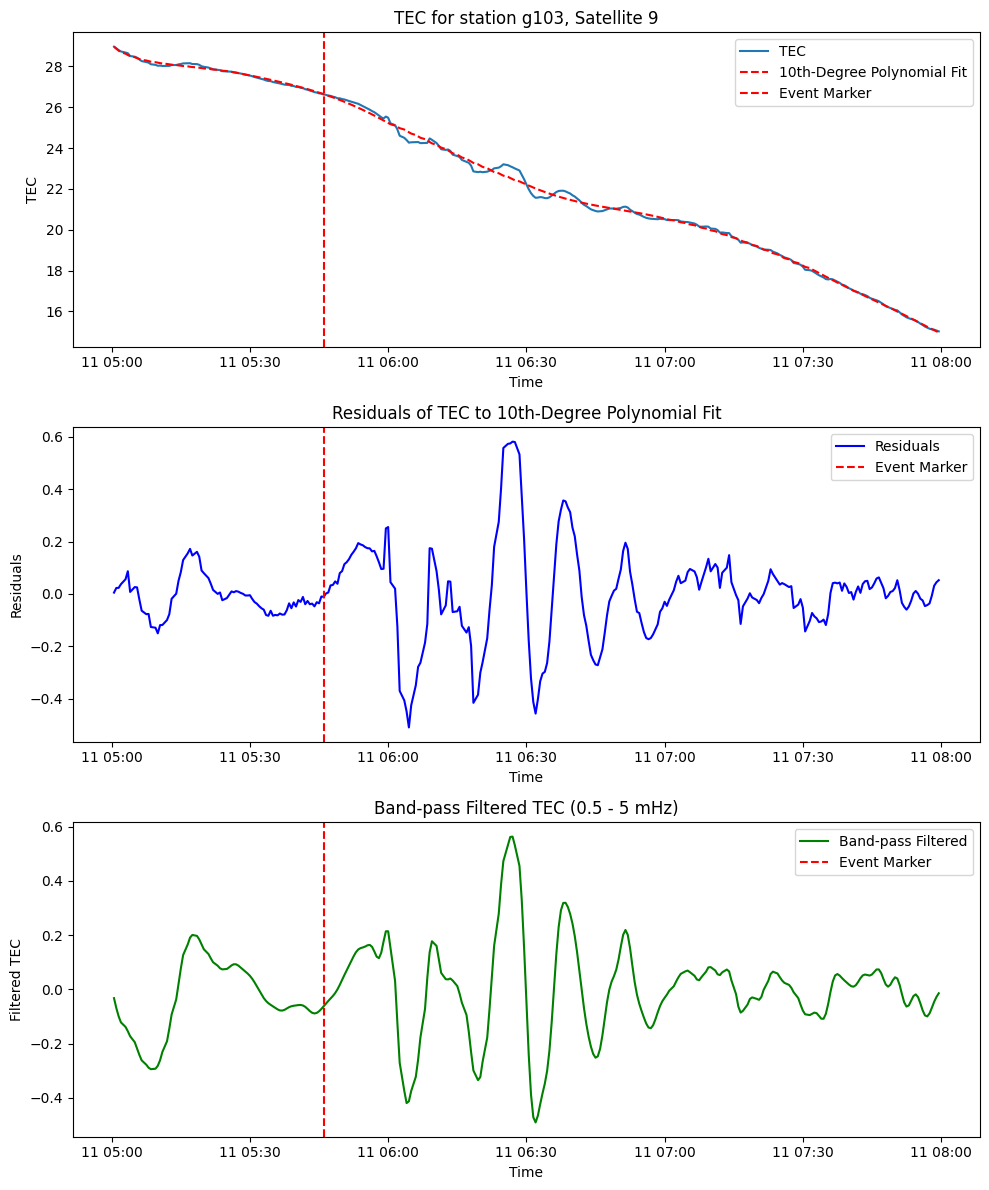

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Load and preprocess data
df = pd.read_csv('tohoku_filtered_data.csv')
df['datetime'] = pd.to_datetime(df['ut1_unix'], unit='s')
df.set_index('datetime', inplace=True)

def get_satellites_in_contact(df, station_id, event_time):
    event_time = pd.to_datetime(event_time)
    df_filtered = df[(df['gps_site'] == station_id) & (df.index == event_time)]
    satellites_in_contact = df_filtered['sat_id'].unique()
    return satellites_in_contact.tolist()
satellites = get_satellites_in_contact(df,'g103',event_time)
print(satellites)

def calculate_residuals(data, order=10):
    time_numeric = np.arange(len(data))
    poly_coeffs = np.polyfit(time_numeric, data, order)
    fitted_values = np.polyval(poly_coeffs, time_numeric)
    residuals = data - fitted_values
    return residuals

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def get_residuals(df, station_id, sat_id, start_time, end_time, tec_type="los_tec"):
    df_filtered = df[(df['gps_site'] == station_id) & 
                     (df['sat_id'] == sat_id) & 
                     (df['datetime'] >= start_time) & 
                     (df['datetime'] <= end_time)]
    residuals = calculate_residuals(df_filtered[tec_type])
    return residuals

def get_band_filtered_data(df, station_id, sat_id, start_time, end_time, lowcut=0.5e-3, highcut=5e-3, tec_type="los_tec"):
    df_filtered = df[(df['gps_site'] == station_id) & 
                     (df['sat_id'] == sat_id) & 
                     (df['datetime'] >= start_time) & 
                     (df['datetime'] <= end_time)]
    sampling_interval = (df_filtered['datetime'].iloc[1] - df_filtered['datetime'].iloc[0]).total_seconds()
    fs = 1 / sampling_interval
    filtered_data = bandpass_filter(df_filtered[tec_type], lowcut, highcut, fs)
    return pd.Series(filtered_data, index=df_filtered['datetime'])

def plot_combined(df, station_id, sat_id, start_time, end_time, event_time, lowcut=0.5e-3, highcut=5e-3, tec_type="los_tec"):
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)
    event_time = pd.to_datetime(event_time)
    
    df_filtered = df[(df['gps_site'] == station_id) & 
                     (df['sat_id'] == sat_id) & 
                     (df['datetime'] >= start_time) & 
                     (df['datetime'] <= end_time)].copy()
    df_filtered.set_index('datetime', inplace=True)
    
    residuals = calculate_residuals(df_filtered[tec_type])
    sampling_interval = (df_filtered.index[1] - df_filtered.index[0]).total_seconds()
    fs = 1 / sampling_interval
    filtered_data = bandpass_filter(df_filtered[tec_type], lowcut, highcut, fs)
    
    # Plot LOS TEC or TEC with Polynomial Fit
    time_numeric = np.arange(len(df_filtered[tec_type]))
    poly_coeffs = np.polyfit(time_numeric, df_filtered[tec_type], 10)
    tec_fit = np.polyval(poly_coeffs, time_numeric)
    
    plt.figure(figsize=(10, 12))
    plt.subplot(3, 1, 1)
    plt.plot(df_filtered.index, df_filtered[tec_type], label=tec_type.upper())
    plt.plot(df_filtered.index, tec_fit, color='red', linestyle='--', label="10th-Degree Polynomial Fit")
    plt.axvline(event_time, color='red', linestyle='--', label="Event Marker")
    plt.title(f"{tec_type.upper()} for station {station_id}, Satellite {sat_id}")
    plt.xlabel("Time")
    plt.ylabel(tec_type.upper())
    plt.legend()

    # Plot Residuals
    plt.subplot(3, 1, 2)
    plt.plot(df_filtered.index, residuals, label="Residuals", color='blue')
    plt.axvline(event_time, color='red', linestyle='--', label="Event Marker")
    plt.title(f"Residuals of {tec_type.upper()} to 10th-Degree Polynomial Fit")
    plt.xlabel("Time")
    plt.ylabel("Residuals")
    plt.legend()
    
    # Plot Band-pass Filtered Data
    plt.subplot(3, 1, 3)
    plt.plot(df_filtered.index, filtered_data, label="Band-pass Filtered", color='green')
    plt.axvline(event_time, color='red', linestyle='--', label="Event Marker")
    plt.title(f"Band-pass Filtered {tec_type.upper()} (0.5 - 5 mHz)")
    plt.xlabel("Time")
    plt.ylabel("Filtered " + tec_type.upper())
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage with option to switch between los_tec and tec
station_id = 'g103'
sat_id = 9
start_time = '2011-03-11 05:00:00'
end_time = '2011-03-11 08:00:00'
event_time = "2011-03-11 05:46:00"

# Call the plot function with either 'los_tec' or 'tec'
df = pd.read_csv('tohoku_filtered_data.csv')
df['datetime'] = pd.to_datetime(df['ut1_unix'], unit='s')
plot_combined(df, station_id, sat_id, start_time, end_time, event_time, tec_type="tec")


In [105]:
def detect_disturbance_time(filtered_data, threshold=0.5):
    """
    Detects the first time where the filtered signal exceeds the threshold in either direction.
    
    Parameters:
    - filtered_data: Series of band-pass filtered VTEC data.
    - threshold: The deviation threshold for disturbance detection in VTEC units.
    
    Returns:
    - disturbance_time: Timestamp of the first threshold exceedance or None if not found.
    """
    for time, value in filtered_data.items():
        if abs(value) > threshold:
            #print(time)
            return time  # Return the timestamp where threshold is first exceeded
        
    print("no thre")
    return None  # Return None if no disturbance is detected

def get_ipp_coordinates(df, satellite_id, timestamp):
    """
    Returns the IPP (Ionospheric Pierce Point) coordinates for a given satellite ID and time.
    
    Parameters:
    - df: DataFrame containing the data with columns for 'sat_id', 'datetime', 'gdlat', and 'gdlon'.
    - satellite_id: The satellite ID for which to find the IPP coordinates.
    - timestamp: The specific time to check (as a string or datetime object).
    
    Returns:
    - (latitude, longitude): Tuple of IPP coordinates in degrees, or None if not found.
    """
    # Ensure timestamp is a datetime object
    timestamp = pd.to_datetime(timestamp)

    # Ensure 'datetime' is set as the index in the DataFrame
    if df.index.name != 'datetime':
        df = df.set_index('datetime')

    # Filter the DataFrame for the given satellite ID and timestamp
    ipp_row = df[(df['sat_id'] == satellite_id) & (df.index == timestamp)]
    
    # Debugging output to confirm the filtered result
    print(f"Filtered IPP row for satellite {satellite_id} at {timestamp}:")
    #print(ipp_row)
    
    # Check if we have data for the given satellite and time
    if not ipp_row.empty:
        latitude = ipp_row['gdlat'].values[0]
        longitude = ipp_row['glon'].values[0]
        return (latitude, longitude)
    else:
        print(f"No IPP coordinates found for satellite ID {satellite_id} at {timestamp}.")
        return None




lowcut=0.5e-3
highcut=5e-3
tec_type ='tec'
sat_id = 9

for sat in satellites:

    filtered_data = get_band_filtered_data(df, station_id, sat, start_time, end_time, lowcut, highcut, tec_type=tec_type)

    time = detect_disturbance_time(filtered_data,0.4)

    lat,long=get_ipp_coordinates(df,sat,time)


    print(f"for sat: {sat} lat: {lat}, long: {long} at time {time}")

Filtered IPP row for satellite 9 at 2011-03-11 06:04:00:
for sat: 9 lat: 39.427814, long: 139.492065 at time 2011-03-11 06:04:00
Filtered IPP row for satellite 15 at 2011-03-11 06:00:30:
for sat: 15 lat: 41.857456, long: 140.945206 at time 2011-03-11 06:00:30
Filtered IPP row for satellite 18 at 2011-03-11 06:25:00:
for sat: 18 lat: 42.583481, long: 137.748093 at time 2011-03-11 06:25:00
Filtered IPP row for satellite 21 at 2011-03-11 06:04:30:
for sat: 21 lat: 39.873798, long: 136.02916 at time 2011-03-11 06:04:30
Filtered IPP row for satellite 26 at 2011-03-11 06:00:30:
for sat: 26 lat: 42.329502, long: 145.01767 at time 2011-03-11 06:00:30
Filtered IPP row for satellite 27 at 2011-03-11 06:03:30:
for sat: 27 lat: 40.436646, long: 140.601273 at time 2011-03-11 06:03:30
Filtered IPP row for satellite 28 at 2011-03-11 06:10:30:
for sat: 28 lat: 46.274014, long: 149.20018 at time 2011-03-11 06:10:30
